### Recurrent Reinforcement Learning for Investment Decisions with Market Regimes

For our project, we have implemented a reinforcement learning agent that learns to trade based on the prevailing market regime. The paper is titled "Regime-switching recurrent reinforcement learning for investment decision making," and it was published in 2012 by Dr. Dietmar Maringer and Dr. Tikesh Ramtohul. The original paper used a Threshold Autoregressive Model and a Smooth Transition Autoregressive model for modeling the regimes, however we have adapted the methodology to work with Markov Regime switching models, in part because of the convenience of the available libraries, as well as the ability for Markov Regime switching models to clearly separate data into distinct market states. For the purposes of this numerical example, we have chosen to work with one asset, the SPY ETF, although the extension to multiple assets is possible. For example, we can have a portfolio that consists of multiple trading agents designed for multiple assets.



In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline

import seaborn as sns
import math

### Model Framework

**RRL Model Description**

The recurrent reinforcement learning (RRL) model is an algorithm under the reinforcement learning paradigm that uses an adaptive policy search algorithm that tries to maximise performance with respect to some measure. The
system is recurrent, so that the current investment decision has a say in shaping.

For this particular application, we can consider the RRL model as as a type of gradient ascent algorithm which aims at optimising some desired criterion. For our criterion, we will use the differential sharpe ratio, which will be discussed shortly. For the purposes of getting a basic numerical example running, we worked with only one asset, the SPY ETF data. 

**Modeling the Trader**

A trader can be modeled by the following function: 

\begin{align*}
F_t &= \tanh \left( \sum_{i=0}^{m-1} w_ir_{t-i} + w_mF_{t-1} + w_{m+1}v \right) \\
&= \tanh(\theta^Tx_t)
\end{align*}

Essentially, this says that our position at time $t$ is based on the trailing $m$-day returns and previous position, with an added bias term. This function generates a value between -1 and 1, and we interpret this as determining what kind of position to take in an asset, assuming these fractional positions are alloewd. Our weights, $w_i$, will be the parameters that our RRL model learns. We can represent the equation conveniently in vector notation, which will also be convenient for when we calculate our subsequent gradients.


**Trading Returns**

Our trading returns are modeled quite simply: they are given by the function

\begin{gather*}
R_t = r_t^f + F_{t-1}(r_t - r_{t-1}^f) - \delta|F_t - F_{t-1}|
\end{gather*}

In this case, our return, $R_t$ is modeled as excess return of the asset multiplied by our position at the previous time step, less the transaction cost, where $\delta$ is parameter that dictates transaction costs as being some fixed proportion of our change in position. For the purpose of this example, we have assumed the risk-free rate is 0, however our model can easily be updated to include some benchmark interest rate. We can also simplify this eqation to consider a simplified trading agent only taking two positions, long and short, hence  the trading position is given by:

\begin{gather*}
R_t = (sgn(F_t-1).r_t - \delta|sgn(F_t)-sgn(F_{t-1})|)
\end{gather*}

**Differential Sharpe Ratio and Gradient Ascent**

As stated before, our model is based on a gradient ascent algorithm that calculates the sharpe ratio based on our trading positions over a period of time. The goal is to update our weights over each trianing epoch, increasing the sharpe ratio each time. Existing literature from Moody et al (1998) demonstrated that optimizing a trading agent with respect to a risk-adjusted performance criteria could outperform trading systems that only aimed to maximize profit or minimize some error criterion. 

We can express the sharpe ratio as follows: 

\begin{gather*}
S_t = \frac{A_t}{\sqrt{B_t - A_t^2}}
\end{gather*}

Where $A_t = \frac{1}{T}\sum_{t=1}^T R_t$ and $B_t = \frac{1}{T}\sum_{t=1}^T R_t^2$. Hence, the gradient that we use to update our weight vector is given by $\frac{dS_t}{d_w}$. From chain rule, we get that

\begin{align*}
\frac{dS_t}{dw} &= \frac{dS_t}{dA} \ \frac{dA}{dw} + \frac{dS_t}{dB} \frac{dB}{dw} \\
&= \sum_{t=1}^{T} \left( \frac{dS_t}{dA} \ \frac{dA}{dR_t} + \frac{dS_t}{dB} \frac{dB}{dR_t} \right) \frac{dR_t}{dw} \\
&= \sum_{t=1}^{T} \left( \frac{dS_t}{dA} \ \frac{dA}{dR_t} + \frac{dS_t}{dB} \frac{dB}{dR_t} \right) \left( \frac{dR_t}{dF_t} \frac{dF_t}{dw} + \frac{dR_t}{dF_{t-1}} \frac{dF_{t-1}}{dw} \right)
\end{align*}

Then, we can calculate the final derivatives: 

\begin{gather*}
\frac{dR_t}{dF_t} = - \delta \cdot sgn (F_t - F_{t-1})
\end{gather*}

\begin{gather*}
\frac{dR_t}{dF_{t-1}} = r_t + \delta \cdot sgn (F_t - F_{t-1})
\end{gather*}

\begin{gather*}
\frac{dF_t}{dw} = (1 - \tanh(\theta^Tx_t)^2)\left( x_t + w_{m} \frac{dF_{t-1}}{dw} \right)
\end{gather*}

Credits to [3] for helping provide further details regarding the derivation and implementation of the differential sharpe ratio in python. We modified this implementation, replicating the implementation in [1], to be compatible with our regime switching model by essentially running two different gradient ascent processes simultaneously. As you can see from the code, depending on the identified regime for a given piece of data, we can calculate the necessary gradients with in a similar fashion to above, however we ensure that the calculated performance is regime (and thus weights) specific. 

**Regime Switching RRL Model**

In order to update the trader to be compatible with our regime switching model, we must slightly modify how we represent our trader function. Whereas before, we had only one set of weights that we were updating, we now need to introduce some binary indicatory variable $G_t$, that helps us determine which prevailing regime we are in. Thus, we can update our trader model as follows:

\begin{gather*}
F_t = y_{t,1}(G_t) + y_{t,2}(1 - G_t) \\
y_{t,j} = \tanh \left( \sum_{i=0}^{m-1} w_{i,j}r_{t-i} + w_{m,j}F_{t-1} + w_{m+1,j}v \right)
\end{gather*}

$F_t$ still represents the position we will take at time $t$, however we now have introduced two intermediary variables $y_{t,1}$ and $y_{t,2}$ that calculate what the positions for the trader would be based on the two weights. These two can be thought of as two coexisting RRL networks that correspond to each regime. The variable $G_t$ essentially determines which value $y_{t,j}$ to take. While the original paper [1] allows for some overlap between the states (meaning, $G_t$ can take a range of values from 0 to 1), our implementation imposes a binary setting. This essentially splits our data set into the two regimes. 

### Code Implementation

In [2]:
class RRL_Base():
    def sharpe_ratio(self, returns):
        return returns.mean() / returns.std()
    
    def returns(self, F, x, delta):
        T = len(x)
        returns = F[0:T - 1] * x[1:T] - delta * np.abs(F[1:T] - F[0:T - 1])
        return np.concatenate([[0], returns]) 

    def performance(self, returns):
        A = np.mean(returns)
        B = np.mean(np.square(returns))
        S = A / np.sqrt(B - A ** 2)
        return A, B, S
    
    def derive_sharp_ret(self, S, A, T, R):
        dSdA = S * (1 + S ** 2) / A
        dSdB = -S ** 3 / 2 / A ** 2
        dAdR = 1. / T
        dBdR = 2. / T * R
        return dSdA, dSdB, dAdR, dBdR

        dRdF = -delta * np.sign(F[t] - F[t-1])
        dRdFp = x[t] + delta * np.sign(F[t] - F[t-1])
        dFdtheta = (1 - F[t] ** 2) * (xt + theta[-1] * dFpdtheta)
        dSdtheta = (dSdA * dAdR + dSdB * dBdR[t]) * (dRdF * dFdtheta + dRdFp * dFpdtheta)
            
    def derive_ret_theta(self, x, theta, t, M, F, dFpdtheta, delta):
        xt = np.concatenate([[1], x[t - M:t], [F[t-1]]])
        
        dRdF = -delta * np.sign(F[t] - F[t-1])
        dRdFp = x[t] + delta * np.sign(F[t] - F[t-1])
        dFdtheta = (1 - F[t] ** 2) * (xt + theta[-1] * dFpdtheta)       
        
        return dRdF, dRdFp, dFdtheta

#### Basic RRL

In [3]:
class RRL(RRL_Base): 
    def __init__(self, theta = [], sharpes = [], F = [], commission = 0): 
        self.theta = theta
        self.sharpes = sharpes
        self.F = F
        self.commission = commission
    
    def positions(self, x, theta):
        M = len(theta) - 2
        T = len(x)
        F = np.zeros(T)
        for t in range(M, T):
            xt = np.concatenate([[1], x[t - M:t], [F[t - 1]]])
            F[t] = np.tanh(np.dot(theta, xt))
        return F
    
    def gradient(self, x, theta, delta):
        F = self.positions(x, theta)
        R = self.returns(F, x, delta)
        T = len(x)
        M = len(theta) - 2
        
        A, B, S = self.performance(R)
        dSdA, dSdB, dAdR, dBdR = self.derive_sharp_ret(S, A, T, R)

        grad = np.zeros(M + 2)  # initialize gradient
        dFpdtheta = np.zeros(M + 2)  # for storing previous dFdtheta

        for t in range(M, T):
            dRdF, dRdFp, dFdtheta = self.derive_ret_theta(x, theta, t, M, F, dFpdtheta, delta)
            dSdtheta = (dSdA * dAdR + dSdB * dBdR[t]) * (dRdF * dFdtheta + dRdFp * dFpdtheta)
            grad = grad + dSdtheta
            dFpdtheta = dFdtheta

        return grad, S
    
    def fit(self, x, epochs = 2000, M = 8, commission = 0.0025, learning_rate = 0.3):
        theta = np.random.rand(M + 2)
        sharpes = np.zeros(epochs) # store sharpes over time
        for i in range(epochs):
            grad, sharpe = self.gradient(x, theta, commission)
            theta = theta + grad * learning_rate
            sharpes[i] = sharpe
        print("finished training")
        
        self.theta = theta
        self.sharpes = sharpes
        self.F = self.positions(x, theta)
        self.commission = commission
    
    def profit(self, x, commission = None):
        if commission is None:
            commission = self.commission
        pos = self.positions(x, self.theta)
        profit = self.returns(pos, x, commission)
        return profit

#### Regime Switching RRL

In [4]:
## inhere sharpe_ratio

class RSRRL(RRL_Base): 
    def __init__(self, theta1 = [], theta2 = [], sharpes = [], F = [], commission = 0): 
        self.theta1 = theta1
        self.theta2 = theta2
        self.sharpes = sharpes
        self.F = F
        self.commission = commission
    
    def positions(self, x, theta0, theta1, state):
        M = len(theta0) - 2
        T = len(x)
        F = np.zeros(T)
        for t in range(M, T):
            xt = np.concatenate([[1], x[t - M:t], [F[t - 1]]])
            if state[t] == 0:
                F[t] = np.tanh(np.dot(theta0, xt))
            else:
                F[t] = np.tanh(np.dot(theta1, xt))
        return F
    
    def gradient(self, x, theta0, theta1, delta, state):
    
        F = self.positions(x, theta0, theta1, state)
        idx0, idx1 = np.equal(state, 0), np.equal(state, 1)
        R = self.returns(F, x, delta)        
        R0, R1 = R[idx0], R[idx1]
        T = len(x)
        T0, T1 = sum(idx0), sum(idx1)
        M = len(theta0) - 2
        
        A, B, S = self.performance(R)    
        
        A0, B0, S0 = self.performance(R0)
        dS0dA0, dS0dB0, dA0dR0, dB0dR0 = self.derive_sharp_ret(S0, A0, T0, R0)
        
        A1, B1, S1 = self.performance(R1)
        dS1dA1, dS1dB1, dA1dR1, dB1dR1 = self.derive_sharp_ret(S1, A1, T1, R)
            
        grad0 = np.zeros(M + 2) 
        grad1 = np.zeros(M + 2) 
        
        i, j = 0, 0
        
        for t in range(M, T):
            if t == M or state[t] != state[t-1]:
                dFpdtheta = np.zeros(M + 2) 
            elif state[t] == state[t-1]:
                dFpdtheta = dFdtheta   
               
            if state[t] == 0:
                dRdF, dRdFp, dFdtheta = self.derive_ret_theta(x, theta0, t, M, F, dFpdtheta, delta)
                dS0dtheta = (dS0dA0 * dA0dR0 + dS0dB0 * dB0dR0[i]) * (dRdF * dFdtheta + dRdFp * dFpdtheta)
                grad0 = grad0 + dS0dtheta
                i += 1
            elif state[t] == 1:
                dRdF, dRdFp, dFdtheta = self.derive_ret_theta(x, theta1, t, M, F, dFpdtheta, delta)
                dS1dtheta = (dS1dA1 * dA1dR1 + dS1dB1 * dB1dR1[j]) * (dRdF * dFdtheta + dRdFp * dFpdtheta)
                grad1 = grad1 + dS1dtheta
                j += 1 
               
        return grad0, grad1, S0, S1, S
    
    def fit(self, x, state, epochs = 2000, M = 8, commission = 0.0025, learning_rate = 0.3):
        
        theta0 = np.random.rand(M + 2)
        theta1 = np.random.rand(M + 2)
        sharpes0 = np.zeros(epochs)  
        sharpes1 = np.zeros(epochs) 
        sharpes = np.zeros(epochs) # store sharpes over time
        
        for i in range(epochs):
            grad0, grad1, sharpe0, sharpe1, sharpe = self.gradient(x, theta0, theta1, commission, state)
            
            theta0 = theta0 + grad0 * learning_rate
            theta1 = theta1 + grad1 * learning_rate

            sharpes0[i] = sharpe0
            sharpes1[i] = sharpe1
            sharpes[i] = sharpe
            
        print("finished training")
        
        self.theta0 = theta0
        self.theta1 = theta1
        self.sharpes0 = sharpes0
        self.sharpes1 = sharpes1
        self.sharpes = sharpes
        self.F = self.positions(x, theta0, theta1, state)
        self.commission = commission
    
    def profit(self, x, state, commission = None):
        if commission is None:
            commission = self.commission
        pos = self.positions(x, self.theta0, self.theta1, state)
        profit = self.returns(pos, x, commission)
        return profit

### Numerical Result

In [5]:
# asset_prices = pd.read_csv('ETF_prices.csv', date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'), index_col = 0) ## '%m/%d/%Y'
asset_returns = pd.read_csv('ETF_returns.csv', date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'), index_col = 0) ## '%m/%d/%Y'
VIX = pd.read_csv('vixcurrent.csv',sep=';',date_parser=lambda dt: pd.to_datetime(dt, format='%m/%d/%Y'), index_col = 0)

returns = asset_returns['SPY']
#returns = asset_returns['QQQ']
VIX = VIX['VIX CLOSE']



#### Basic RRL

In [6]:
VIX=np.array(VIX)
x = np.array(returns)

N = 1000
P = 250
x_train = x[-(N+P):-P]
x_test = x[-P:]
VIX_train = VIX[-(N+P):-P]
VIX_test = VIX[-P:]

std = np.std(x_train)
mean = np.mean(x_train)

x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

x_all = (x - mean) / std
#x_all = x

In [7]:
rrl = RRL()

In [8]:
np.random.seed(0)
rrl.fit(x_train, epochs = 1000, M = 8, commission = 0, learning_rate = 0.3)

finished training


In [9]:
rrl.theta

array([-1.1411553 ,  1.05002936, -0.37366644,  2.57138229, -1.33410894,
       -0.28699256,  0.04886538,  1.45640199,  0.17496735,  0.87433378])

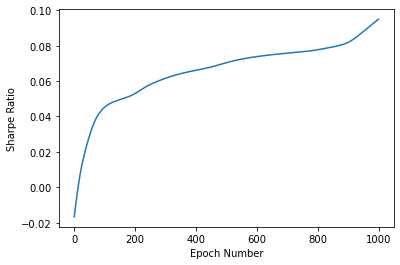

In [10]:
plt.plot(rrl.sharpes)
plt.xlabel('Epoch Number')
plt.ylabel('Sharpe Ratio');

In [11]:
rrl.sharpes[-1]

0.09489443697438815

In [12]:
train_returns = rrl.profit(x_train, commission = 0)  

Text(0.5, 1.0, 'RL Model vs. Buy and Hold - Training Data')

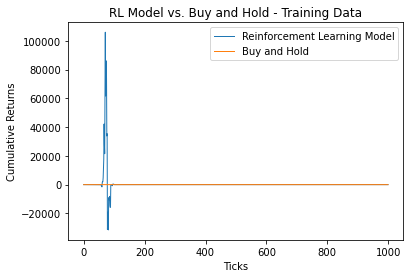

In [13]:
plt.plot((1+train_returns).cumprod(), label="Reinforcement Learning Model", linewidth=1)
plt.plot((1+x_train).cumprod(), label="Buy and Hold", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns');
plt.legend()
plt.title("RL Model vs. Buy and Hold - Training Data")

Text(0.5, 1.0, 'RL Model vs. Buy and Hold - Test Data')

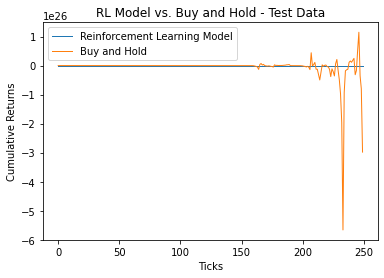

In [14]:
test_returns = rrl.profit(x_test, commission =0)  
plt.plot((1+test_returns).cumprod(), label="Reinforcement Learning Model", linewidth=1)
plt.plot((1+x_test).cumprod(), label="Buy and Hold", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns');
plt.legend()
plt.title("RL Model vs. Buy and Hold - Test Data")

**Sharpe Ratio for Buy & Hold Strategy**

In [15]:
x_sum = np.sum(x_test) / len(x_test)
x_sum_sq = np.sum(np.square(x_test)) / len(x_test)

sharpe_x = x_sum / np.sqrt(x_sum_sq - x_sum**2)
sharpe_x

0.00803784921446579

**Sharpe Ratio for RRL model**

In [16]:
ret_sum = np.sum(test_returns) / len(test_returns)
ret_sum_sq = np.sum(np.square(test_returns)) / len(test_returns)

sharpe_rrl = ret_sum / np.sqrt(ret_sum_sq - ret_sum**2)
sharpe_rrl

0.1391304156679164

#### Regime Switching RRL

We opted for using the hidden markov model implementation 

In [17]:
from hmmlearn import hmm

model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=1000)
model_VIX = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=1000)

model.fit(x_train.reshape(-1,1))
model_VIX.fit(VIX_train.reshape(-1,1))

GaussianHMM(covariance_type='full', n_components=2, n_iter=1000)

In [18]:
states_train = model.predict(x_train.reshape(-1,1))
states_train_VIX = model_VIX.predict(VIX_train.reshape(-1,1))

In [19]:
x_graph_data = asset_returns[-(N+P):-P]

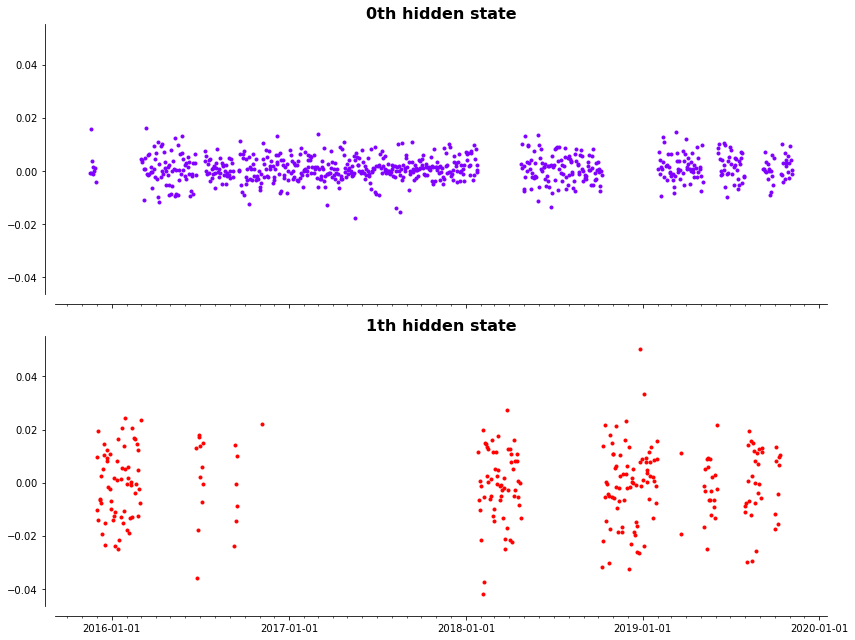

In [20]:
fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = states_train == i
    ax.plot_date(x_graph_data.index.values[mask],
                 x_graph_data.SPY.values[mask],
                 ".", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)

plt.tight_layout()

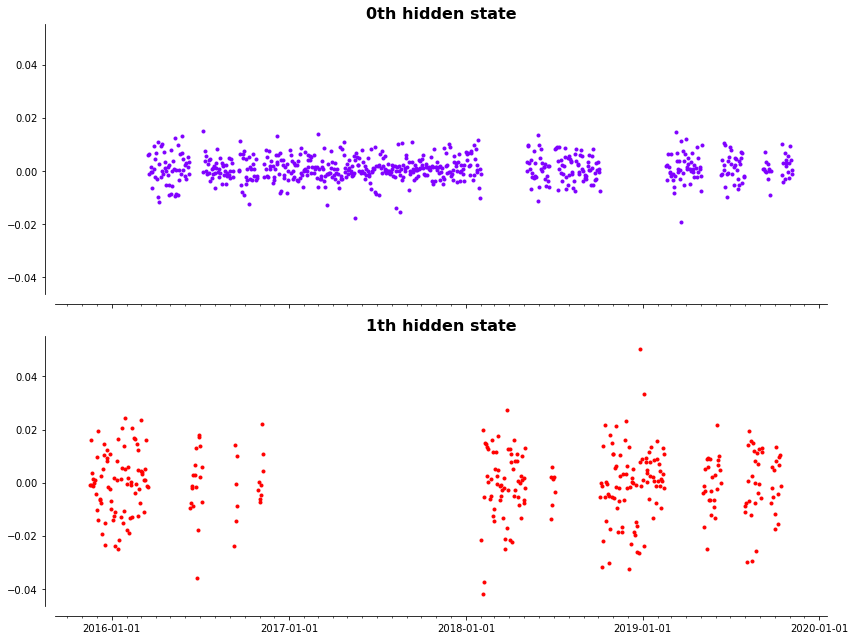

In [27]:
fig, axs = plt.subplots(model_VIX.n_components, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model_VIX.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = states_train_VIX == i
    ax.plot_date(x_graph_data.index.values[mask],
                 x_graph_data.SPY.values[mask],
                 ".", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)

plt.tight_layout()

In [21]:
rsrrl = RSRRL()
rsrrl_VIX = RSRRL()

np.random.seed(0)
rsrrl.fit(x_train, state = states_train, epochs = 1000, M = 8, commission = 0, learning_rate = 0.3)

np.random.seed(0)
rsrrl_VIX.fit(x_train, state = states_train_VIX, epochs = 1000, M = 8, commission = 0, learning_rate = 0.3)

finished training
finished training


In [22]:
rsrrl.theta0, rsrrl.theta1

(array([ 2.2156817 , -0.22805243, -0.66593826, -0.42736226,  1.104924  ,
        -1.21670809,  0.05048132,  0.00981222,  3.58064926, -0.15169919]),
 array([-2.76154326,  1.82457514, -0.91915317,  2.64039923, -1.45722737,
        -0.74126808,  0.57638908,  2.08817595, -1.11768515, -0.71457949]))

In [23]:
rsrrl_VIX.theta0, rsrrl_VIX.theta1

(array([ 2.56074742,  1.44706146, -0.99613559,  0.83646595, -0.89236078,
         2.54310715, -4.29711318,  1.88117803, -0.8641672 , -2.18217378]),
 array([-2.61624768,  1.80904671, -1.18392898,  2.73534024, -1.36945751,
        -0.44762955,  0.88820673,  2.31653478, -1.09169023, -0.15654269]))

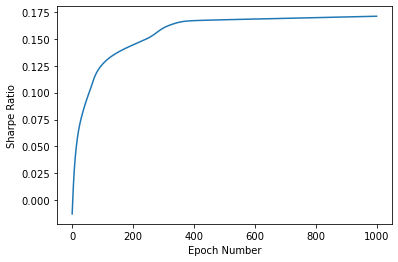

In [24]:
plt.plot(rsrrl.sharpes)
plt.xlabel('Epoch Number')
plt.ylabel('Sharpe Ratio');

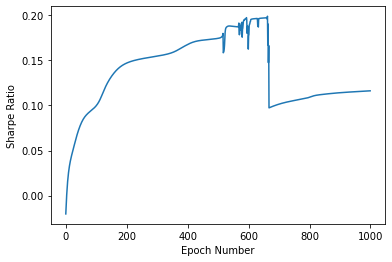

In [25]:
plt.plot(rsrrl_VIX.sharpes)
plt.xlabel('Epoch Number')
plt.ylabel('Sharpe Ratio');

In [26]:
rsrrl.sharpes[-1]

0.17110312788251883

In [27]:
rsrrl_VIX.sharpes[-1]

0.11611154627022373

In [28]:
train_returns_rsrrl = rsrrl.profit(x_train, states_train, commission = 0)  
train_returns_rsrrl_VIX = rsrrl_VIX.profit(x_train, states_train_VIX, commission = 0)  

Text(0.5, 1.0, 'RSRL Model vs. RL Model vs. Buy and Hold - Training Data')

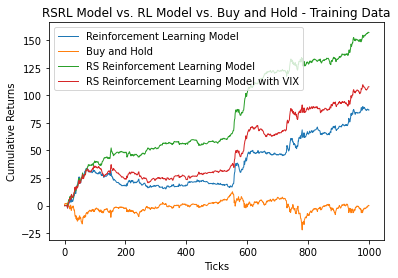

In [29]:
plt.plot((train_returns).cumsum(), label="Reinforcement Learning Model", linewidth=1)
plt.plot(x_train.cumsum(), label="Buy and Hold", linewidth=1)
plt.plot(train_returns_rsrrl.cumsum(), label="RS Reinforcement Learning Model", linewidth=1)
plt.plot((train_returns_rsrrl_VIX).cumsum(), label="RS Reinforcement Learning Model with VIX", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns');
plt.legend()
plt.title("RSRL Model vs. RL Model vs. Buy and Hold - Training Data")

**Determining The Hidden State on test data using a window of past trading days (Rolling window)**

In [30]:
window = 250;
states_test2 = [];
for i in range(P):
    days = x_all[-P-window+i:-P+i]
    states = model.predict(days.reshape(-1,1))
    states_test2.append(states[-1])
    
states_test2 = np.asarray(states_test2)
states_test2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1])

In [31]:
window = 250;
states_test2_VIX = [];
for i in range(P):
    days = VIX[-P-window+i:-P+i]
    states_VIX = model_VIX.predict(days.reshape(-1,1))
    states_test2_VIX.append(states_VIX[-1])
    
states_test2_VIX = np.asarray(states_test2_VIX)
states_test2_VIX

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [32]:
test_returns_rsrrl2 = rsrrl.profit(x_test,states_test2,commission = 0)
test_returns_rsrrl2_VIX = rsrrl_VIX.profit(x_test,states_test2_VIX,commission = 0)

Text(0.5, 1.0, 'RSRL Model vs. RL Model vs. Buy and Hold - Test Data')

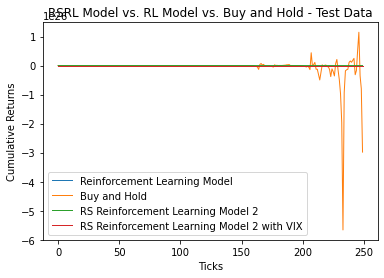

In [33]:
plt.plot((1+test_returns).cumprod(), label="Reinforcement Learning Model", linewidth=1)
plt.plot((1+x_test).cumprod(), label="Buy and Hold", linewidth=1)
plt.plot((1+test_returns_rsrrl2).cumprod(), label="RS Reinforcement Learning Model 2", linewidth=1)
plt.plot((1+test_returns_rsrrl2_VIX).cumprod(), label="RS Reinforcement Learning Model 2 with VIX", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns');
plt.legend()
plt.title("RSRL Model vs. RL Model vs. Buy and Hold - Test Data")

In [34]:
ret_sum_rsrrl2 = np.sum(test_returns_rsrrl2) / len(test_returns_rsrrl2)
ret_sum_sq_rsrrl2 = np.sum(np.square(test_returns_rsrrl2)) / len(test_returns_rsrrl2)

sharpe_rsrrl2 = ret_sum_rsrrl2 / np.sqrt(ret_sum_sq_rsrrl2 - ret_sum_rsrrl2**2)
sharpe_rsrrl2

0.13672698597276536

In [35]:
ret_sum_rsrrl2_VIX = np.sum(test_returns_rsrrl2_VIX) / len(test_returns_rsrrl2_VIX)
ret_sum_sq_rsrrl2_VIX = np.sum(np.square(test_returns_rsrrl2_VIX)) / len(test_returns_rsrrl2_VIX)

sharpe_rsrrl2_VIX = ret_sum_rsrrl2_VIX / np.sqrt(ret_sum_sq_rsrrl2_VIX - ret_sum_rsrrl2_VIX**2)
sharpe_rsrrl2_VIX

0.12656630178785347

**Determining The Hidden State for test data based on all days up to newest day(Expanding window)**

In [36]:
states_test3 = [];
for i in range(P):
    days = x_all[-(N+P):-P+i]
    states = model.predict(days.reshape(-1,1))
    states_test3.append(states[-1])
    
states_test3= np.asarray(states_test3)
states_test3

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1])

In [37]:
states_test3_VIX = [];
for i in range(P):
    days = VIX[-(N+P):-P+i]
    states = model_VIX.predict(days.reshape(-1,1))
    states_test3_VIX.append(states[-1])
    
states_test3_VIX = np.asarray(states_test3_VIX)
states_test3_VIX

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [38]:
test_returns_rsrrl3 = rsrrl.profit(x_test,states_test3,commission = 0)
test_returns_rsrrl3_VIX = rsrrl_VIX.profit(x_test,states_test3_VIX,commission = 0)

Text(0.5, 1.0, 'RSRL Model vs. RL Model vs. Buy and Hold - Test Data')

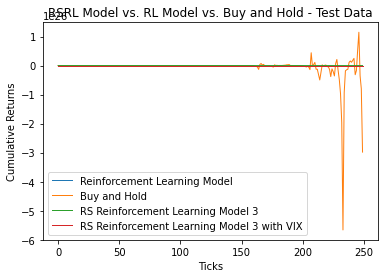

In [39]:
plt.plot((1+test_returns).cumprod(), label="Reinforcement Learning Model", linewidth=1)
plt.plot((1+x_test).cumprod(), label="Buy and Hold", linewidth=1)
plt.plot((1+test_returns_rsrrl3).cumprod(), label="RS Reinforcement Learning Model 3", linewidth=1)
plt.plot((1+test_returns_rsrrl3_VIX).cumprod(), label="RS Reinforcement Learning Model 3 with VIX", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns');
plt.legend()
plt.title("RSRL Model vs. RL Model vs. Buy and Hold - Test Data")

In [40]:
ret_sum_rsrrl3 = np.sum(test_returns_rsrrl3) / len(test_returns_rsrrl3)
ret_sum_sq_rsrrl3 = np.sum(np.square(test_returns_rsrrl3)) / len(test_returns_rsrrl3)

sharpe_rsrrl3 = ret_sum_rsrrl3 / np.sqrt(ret_sum_sq_rsrrl3 - ret_sum_rsrrl3**2)
sharpe_rsrrl3

0.13672698597276536

In [41]:
ret_sum_rsrrl3_VIX = np.sum(test_returns_rsrrl3_VIX) / len(test_returns_rsrrl3_VIX)
ret_sum_sq_rsrrl3_VIX = np.sum(np.square(test_returns_rsrrl3_VIX)) / len(test_returns_rsrrl3_VIX)

sharpe_rsrrl3_VIX = ret_sum_rsrrl3_VIX / np.sqrt(ret_sum_sq_rsrrl3_VIX - ret_sum_rsrrl3_VIX**2)
sharpe_rsrrl3_VIX

0.12656630178785347

### ROLLING WINDOW WITH SMALL TRAINING SAMPLE

In [42]:
def train_and_test(x_train,x_test,window_size):
    model_VIX = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=1000)
    model_VIX.fit(x_train.reshape(-1,1))
    states_train = model_VIX.predict(x_train.reshape(-1,1))
    states_test = []
    for i in range( window_size ) :
        days = VIX[0:window_size+i]
        states = model_VIX.predict(days.reshape(-1,1))
        states_test.append(states[-1])
    return states_test

In [43]:
def find_states(window_size):
   print("here")
   states_VIX=[]
   for j in range(VIX.size-N-P-window_size, VIX.size, window_size):
       states = train_and_test(VIX[j:j+window_size] , VIX[j+window_size:j+(2*window_size) ] , window_size)
       for k in range(len(states)):
          states_VIX.append(states[k])
       #print("size of states_VIX is" , len(states_VIX))
   return states_VIX

In [44]:
states_VIX_all = []
for i in range(10,101,10):
    print(i)
    result = find_states(i)
    print("len of result is",len(result))
    states_VIX_all.append(result)

10
here
len of result is 1260
20
here
len of result is 1280
30
here
len of result is 1290
40
here
len of result is 1320
50
here
len of result is 1300
60
here
len of result is 1320
70
here
len of result is 1330
80
here
len of result is 1360
90
here
len of result is 1350
100
here
len of result is 1400


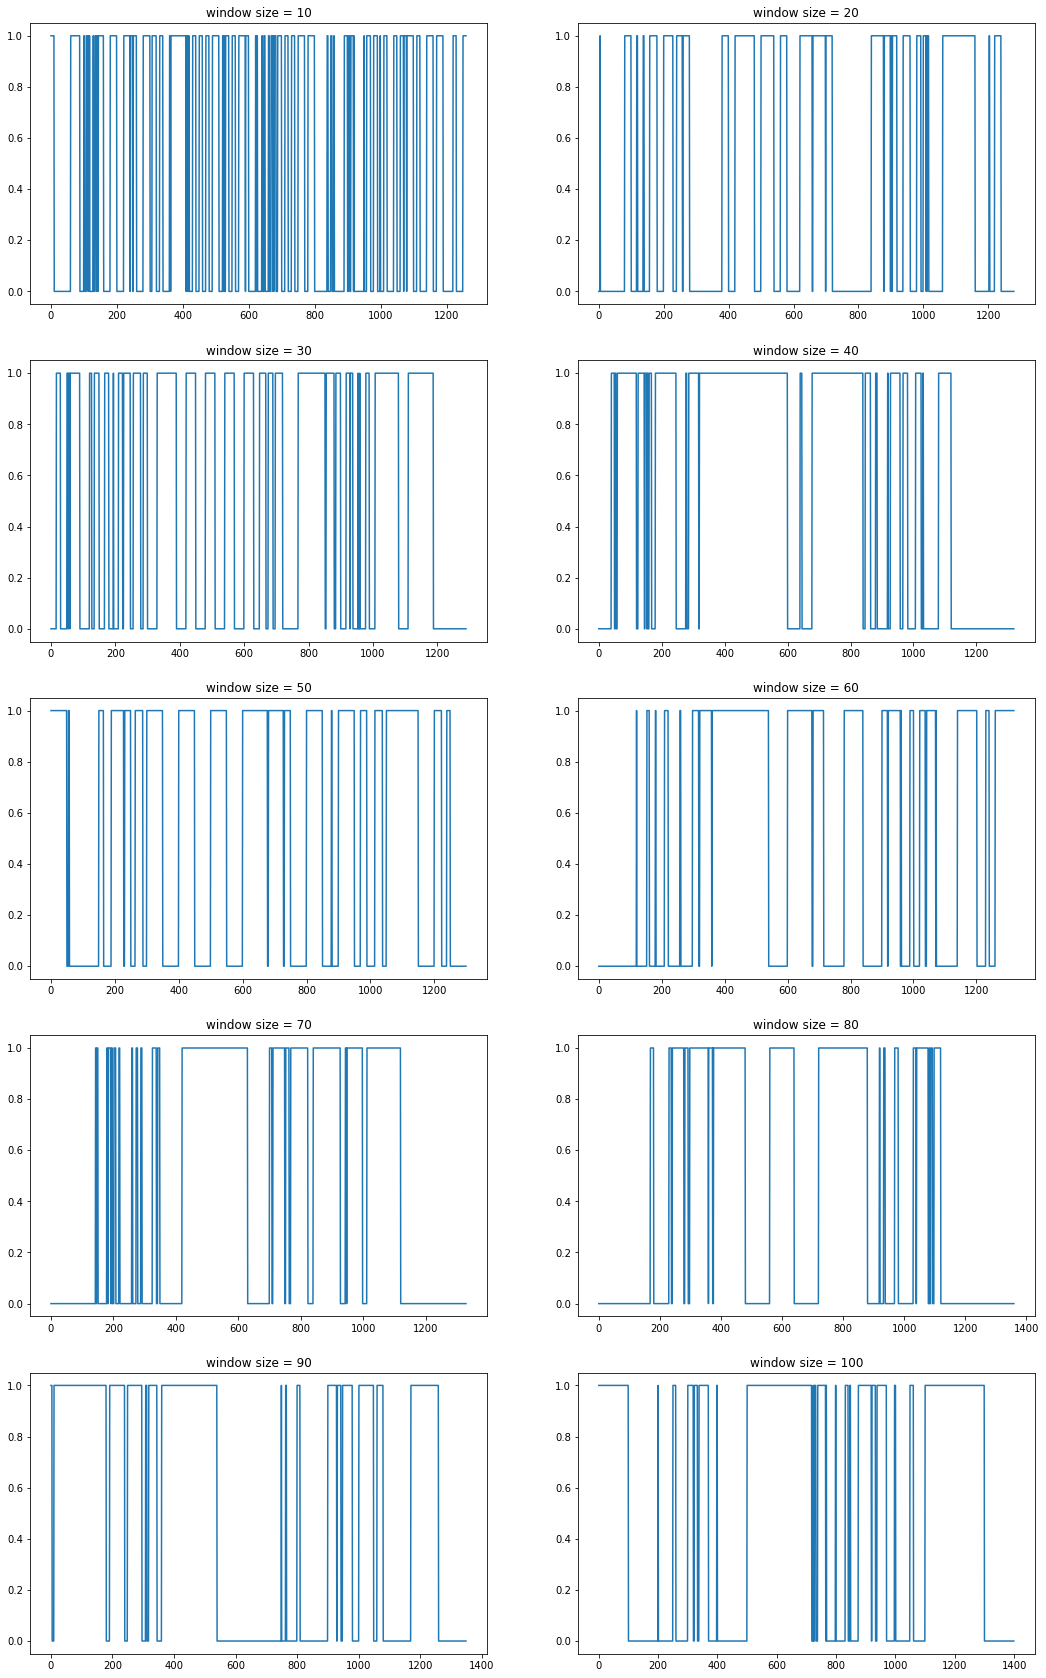

In [45]:
fig, axes = plt.subplots(5,2, figsize = (18,30))
axes[0,0].set_title('window size = 10')
axes[0,0].plot(states_VIX_all[0])
axes[0,1].set_title('window size = 20')
axes[0,1].plot(states_VIX_all[1])
axes[1,0].set_title('window size = 30')
axes[1,0].plot(states_VIX_all[2])
axes[1,1].set_title('window size = 40')
axes[1,1].plot(states_VIX_all[3])
axes[2,0].set_title('window size = 50')
axes[2,0].plot(states_VIX_all[4])
axes[2,1].set_title('window size = 60')
axes[2,1].plot(states_VIX_all[5])
axes[3,0].set_title('window size = 70')
axes[3,0].plot(states_VIX_all[6])
axes[3,1].set_title('window size = 80')
axes[3,1].plot(states_VIX_all[7])
axes[4,0].set_title('window size = 90')
axes[4,0].plot(states_VIX_all[8])
axes[4,1].set_title('window size = 100')
axes[4,1].plot(states_VIX_all[9])

In [46]:
states_VIX_train = states_VIX_all[4][-(N+P):-P]

In [47]:
states_VIX_test = states_VIX_all[4][-P:]

In [48]:
rsrrl_VIX = RSRRL()

In [49]:
np.random.seed(0)
rsrrl_VIX.fit(x_train, state = states_VIX_train, epochs = 1000, M = 8, commission = 0, learning_rate = 0.3)

finished training


In [50]:
rsrrl_VIX.theta0

array([-0.03597696,  1.42627237,  0.57068301,  2.67940902, -0.01417311,
        1.47501243,  2.06207794,  1.55627612,  0.9821885 ,  1.69920389])

In [51]:
rsrrl_VIX.theta1

array([-2.20638606, -0.63341612,  0.09932957,  3.40687115, -1.10297364,
       -0.33993372, -0.35667209,  1.66282479,  0.34714971,  1.57872466])

In [52]:
train_returns_rsrrl_VIX = rsrrl_VIX.profit(x_train, states_VIX_train, commission = 0)  

Text(0.5, 1.0, 'RSRL Model vs. RL Model vs. Buy and Hold - Training Data')

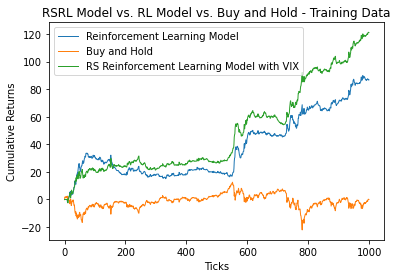

In [53]:
plt.plot(train_returns.cumsum(), label="Reinforcement Learning Model", linewidth=1)
plt.plot(x_train.cumsum(), label="Buy and Hold", linewidth=1)
plt.plot(train_returns_rsrrl_VIX.cumsum(), label="RS Reinforcement Learning Model with VIX", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns');
plt.legend()
plt.title("RSRL Model vs. RL Model vs. Buy and Hold - Training Data")

In [54]:
test_returns_rsrrl_VIX = rsrrl_VIX.profit(x_test,states_VIX_test,commission = 0)

Text(0.5, 1.0, 'RSRL Model vs. RL Model vs. Buy and Hold - Test Data')

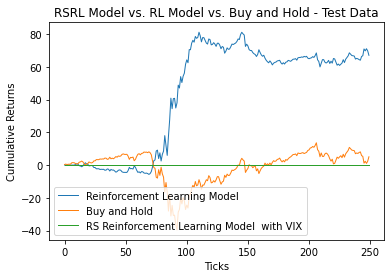

In [56]:
plt.plot(test_returns_rsrrl_VIX.cumsum(), label="Reinforcement Learning Model", linewidth=1)
plt.plot(x_test.cumsum(), label="Buy and Hold", linewidth=1)
#plt.plot((test_returns_rsrrl2).cumprod(), label="RS Reinforcement Learning Model 2", linewidth=1)
plt.plot(test_returns_rsrrl_VIX.cumprod(), label="RS Reinforcement Learning Model  with VIX", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns');
plt.legend()
plt.title("RSRL Model vs. RL Model vs. Buy and Hold - Test Data")

In [61]:
math.exp((test_returns_rsrrl_VIX*std)+mean)

TypeError: only size-1 arrays can be converted to Python scalars

### Future Work
<br>

#### 1. Training Window for Regime Detection
##### 1.1 Prelimary results is based on a one-time fixed time windonw training + a one-time fixed time window test
##### 1.2 How long a training window should be the balance the accuracy and noise of regime 
##### 1.3 If using a rolling window, should a fixed length window used or a flexible window
<br>

#### 2. Better Model for Regime Detection 
##### 1.1 Currently using a simple but popular HMM model for regime detection
##### 1.2 Can we learning regime together with the position within a same model? Set state indicator whose value is 0 or 1 also as a parameter for learning. And learn state indicator within the recurrent network
##### 1.3 Bayesian Online Learning for Changepoint Detection
<br>

**Conclusion**

Initial results seem promising, however, there are several improvements that do need to be made into the model.

Firstly, we want to redesign the training method as a rolling window exercise. Currently, the model takes in a huge period of training data, and trains and tests over large periods. However, I think in order to replicate a realistic trading setting, a rolling window exercise is more appropriate. Another potential modification to the exercise is to use an exponential weighted moving average approach toward determining the weights. This can allow us to simplify the number of paramters learned to only one.

**References:**

1. Regime-switching recurrent reinforcement learning for investment decision making, https://core.ac.uk/download/pdf/159156599.pdf 
2. https://teddykoker.com/2019/06/trading-with-reinforcement-learning-in-python-part-ii-application/ 
3. http://cs229.stanford.edu/proj2006/Molina-StockTradingWithRecurrentReinforcementLearning.pdf 
4. https://hmmlearn.readthedocs.io/en/latest/tutorial.html 
5. https://towardsdatascience.com/when-to-buy-the-dip-e2e128d737a7